In [1]:
# import libraries
import pandas as pd 
import numpy as np
pd.set_option('display.max_rows',None)
pd.set_option('display.max_columns',None)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.metrics import accuracy_score, precision_score, f1_score, adjusted_rand_score
from sklearn.model_selection import RandomizedSearchCV
from kmodes.kprototypes import KPrototypes
from sklearn.preprocessing import MinMaxScaler
from plotnine import*
import plotnine
from prince import FAMD

In [2]:
#read dataset
pd.set_option('display.max_colwidth', -1)
df = pd.read_csv('/home/juanjo/Documents/Academico/Maestria/proyecto de especializacion/Dataset/DASS_data_21.02.19/data.csv', delimiter='\t')
fields = pd.read_csv('/home/juanjo/Documents/Academico/Maestria/proyecto de especializacion/Dataset/DASS_data_21.02.19/fields_description.csv' , delimiter=';')

<ipython-input-2-0ba19c2358c0>:2: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.


In [3]:
# Getting the fields tables
fields['Description'] = fields['Description'].str.replace('"', '')
fields['Description'] = fields['Description'].str.replace("'", "")
Fields_questions = fields[fields['Field'].str.contains('Q')]
Fields_questions.to_latex('/home/juanjo/Documents/Academico/Maestria/proyecto de especializacion/Results/fields_questions.txt',index = False)
Fields_demo = fields[fields['Field'].str.contains('Q') == False]
Fields_demo = Fields_demo [fields['Field'].str.contains('major') == False]
Fields_demo.to_latex('/home/juanjo/Documents/Academico/Maestria/proyecto de especializacion/Results/fields_demo.txt',index = False)

<ipython-input-3-212eba861944>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [4]:
fields

Field  \
0   Q1            
1   Q2            
2   Q3            
3   Q4            
4   Q5            
5   Q6            
6   Q7            
7   Q8            
8   Q9            
9   Q10           
10  Q11           
11  Q12           
12  Q13           
13  Q14           
14  Q15           
15  Q16           
16  Q17           
17  Q18           
18  Q19           
19  Q20           
20  Q21           
21  Q22           
22  Q23           
23  Q24           
24  Q25           
25  Q26           
26  Q27           
27  Q28           
28  Q29           
29  Q30           
30  Q31           
31  Q32           
32  Q33           
33  Q34           
34  Q35           
35  Q36           
36  Q37           
37  Q38           
38  Q39           
39  Q40           
40  Q41           
41  Q42           
42  TIPI1         
43  TIPI2         
44  TIPI3         
45  TIPI4         
46  TIPI5         
47  TIPI6         
48  TIPI7         
49  TIPI8         
50  TIPI9         
51  TIPI10        
52  education     
53  urban         
54  gender        
55  age           
56  religion      
57  orientation   
58  race          
59  married       
60  familysize    
61  major         

                                                                                                                                                                                                Description  
0   I found myself getting upset by quite trivial things.                                                                                                                                                    
1   I was aware of dryness of my mouth.                                                                                                                                                                      
2   I couldnt seem to experience any positive feeling at all.                                                                                                                                                
3   I experienced breathing difficulty (eg, excessively rapid breathing, breathlessness in the absence of physical exertion).                                                                                
4   I just couldnt seem to get going.                                                                                                                                                                        
5   I tended to over-react to situations.                                                                                                                                                                    
6   I had a feeling of shakiness (eg, legs going to give way).                                                                                                                                               
7   I found it difficult to relax.                                                                                                                                                                           
8   I found myself in situations that made me so anxious I was most relieved when they ended.                                                                                                                
9   I felt that I had nothing to look forward to.                                                                                                                                                            
10  I found myself getting upset rather easily.                                                                                                                                                              
11  I felt that I was using a lot of nervous energy.                                                                                                                                                         
12  I felt sad and depressed.                                                                                                         

In [5]:
#filter variables
original_variables = list(df.columns)
questions = [k for k in original_variables if 'Q' in k]
not_questions = [k for k in original_variables if 'Q' not in k]
answers = [k for k in questions if 'A' in k]
VCL = [k for k in original_variables if 'VCL'  in k]
not_vcl = [k for k in not_questions if 'VCL'  not in k]
not_useful = ['introelapse', 'testelapse','surveyelapse','source', 'engnat'
              ,'screensize','uniquenetworklocation','major', 'hand','voted','country',]
useful = [k for k in not_vcl if k not in not_useful]
tipi = [i for  i in useful if 'T' in i]
useful_num = tipi + ['age', 'familysize']
useful_cat = [i for i in useful if i not in useful_num]
filt_variables = answers + useful
total_num = answers + useful_num
df_filt = df[filt_variables]
#sustracting 1 due to the nature of the original asigment
df_filt[answers] = df_filt[answers]-1

/home/juanjo/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [6]:
#getting a overview of the dataset
df_filt.describe()

Q1A           Q2A           Q3A           Q4A           Q5A  \
count  39775.000000  39775.000000  39775.000000  39775.000000  39775.000000   
mean   1.619485      1.172269      1.226097      0.950170      1.521458       
std    1.032117      1.111563      1.038526      1.042218      1.069908       
min    0.000000      0.000000      0.000000      0.000000      0.000000       
25%    1.000000      0.000000      0.000000      0.000000      1.000000       
50%    2.000000      1.000000      1.000000      1.000000      1.000000       
75%    3.000000      2.000000      2.000000      2.000000      2.000000       
max    3.000000      3.000000      3.000000      3.000000      3.000000       

                Q6A           Q7A           Q8A           Q9A          Q10A  \
count  39775.000000  39775.000000  39775.000000  39775.000000  39775.000000   
mean   1.540214      0.924928      1.480427      1.669591      1.447316       
std    1.049672      1.033528      1.052436      1.067866      1.139350       
min    0.000000      0.000000      0.000000      0.000000      0.000000       
25%    1.000000      0.000000      1.000000      1.000000      0.000000       
50%    1.000000      1.000000      1.000000      2.000000      1.000000       
75%    2.000000      2.000000      2.000000      3.000000      3.000000       
max    3.000000      3.000000      3.000000      3.000000      3.000000       

               Q11A          Q12A          Q13A          Q14A          Q15A  \
count  39775.000000  39775.000000  39775.000000  39775.000000  39775.000000   
mean   1.803294      1.425669      1.784538      1.580264      0.826901       
std    1.048995      1.065960      1.073779      1.079780      0.985759       
min    0.000000      0.000000      0.000000      0.000000      0.000000       
25%    1.000000      1.000000      1.000000      1.000000      0.000000       
50%    2.000000      1.000000      2.000000      1.000000      1.000000       
75%    3.000000      2.000000      3.000000      3.000000      1.000000       
max    3.000000      3.000000      3.000000      3.000000      3.000000       

               Q16A          Q17A          Q18A          Q19A          Q20A  \
count  39775.000000  39775.000000  39775.000000  39775.000000  39775.000000   
mean   1.519573      1.658605      1.477536      0.946298      1.323042       
std    1.110826      1.157063      1.067700      1.071949      1.115588       
min    0.000000      0.000000      0.000000      0.000000      0.000000       
25%    1.000000      1.000000      1.000000      0.000000      0.000000       
50%    1.000000      2.000000      1.000000      1.000000      1.000000       
75%    3.000000      3.000000      2.000000      2.000000      2.000000       
max    3.000000      3.000000      3.000000      3.000000      3.000000       

               Q21A          Q22A          Q23A          Q24A          Q25A  \
count  39775.000000  39775.000000  39775.000000  39775.000000  39775.000000   
mean   1.349591      1.344488      0.562288      1.437109      1.184312       
std    1.166096      1.029775      0.861848      1.050809      1.079551       
min    0.000000      0.000000      0.000000      0.000000      0.000000       
25%    0.000000      1.000000      0.000000      1.000000      0.000000       
50%    1.000000      1.000000      0.000000      1.000000      1.000000       
75%    2.000000      2.000000      1.000000      2.000000      2.000000       
max    3.000000      3.000000      3.000000      3.000000      3.000000       

               Q26A          Q27A          Q28A          Q29A          Q30A  \
count  39775.000000  39775.000000  39775.000000  39775.000000  39775.000000   
mean   1.658580      1.612344      1.217272      1.653300      1.392332       
std    1.066779      1.050274      1.074164      1.058136      1.077906       
min    0.000000      0.000000      0.000000      0.000000      0.000000       
25%    1.000000      1.000000      0.000000      1.000000    

In [8]:
df_filt.shape

(39775, 61)

In [7]:
#fitering rows that contains outliers in age and family size
df_filt = df_filt[df_filt['familysize']<20]
df_filt = df_filt[df_filt['age']<90]
df_filt = df_filt.reset_index(drop=True)

In [8]:
df_filt.shape

(39759, 61)

In [9]:
#defininf the questions corresponding to each category
Depression =[3, 5, 10, 13, 16, 17, 21, 24, 26, 31, 34, 37, 38, 42]
depression_answers = ['Q' + str(i)+ 'A' for i in Depression ]
Anxiety= [2, 4, 7, 9, 15, 19, 20, 23, 25, 28, 30, 36, 40, 41]
anxiety_answers = ['Q' + str(i)+ 'A' for i in Anxiety]
Stress= [1, 6, 8, 11, 12, 14, 18, 22, 27, 29, 32, 33, 35, 39]
stress_answers = ['Q' + str(i)+ 'A' for i in Stress ]
depression_str = str(Depression).replace('[', '').replace(']', '')
anxiety_str = str(Anxiety).replace('[', '').replace(']', '')
stress_str = str(Stress).replace('[', '').replace(']', '')
questions_df = pd.DataFrame(data=[depression_str , anxiety_str , stress_str ], columns = ['Questions'], index = ['Depression', 'Anxiety', 'Stress'])
questions_df.to_latex('/home/juanjo/Documents/Academico/Maestria/proyecto de especializacion/Results/Questions_by_condition.txt')

In [10]:
#constructing the datasets out of each category
df_depression=df_filt[depression_answers]
df_anxiety = df_filt[anxiety_answers]
df_stress = df_filt[stress_answers]

In [11]:
#getting the scores of each category
df_depression['score'] = df_depression.sum(axis=1)
df_anxiety['score'] = df_anxiety.sum(axis=1)
df_stress['score'] = df_stress.sum(axis=1)

<ipython-input-11-9309d4e8341a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<ipython-input-11-9309d4e8341a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<ipython-input-11-9309d4e8341a>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [125]:
names  = ['Stress', 'Anxiety', 'Depression']
corr = pd.concat([df_stress['score'], df_anxiety['score'], df_depression['score']], axis = 1 ).corr(method = 'pearson').round(2)
corr.columns = names
corr.index = names
corr.to_latex('/home/juanjo/Documents/Academico/Maestria/proyecto de especializacion/Results/Correlation_between_conditions.txt')
corr

Stress  Anxiety  Depression
Stress      1.00    0.80     0.74      
Anxiety     0.80    1.00     0.67      
Depression  0.74    0.67     1.00

In [12]:
#defining the limits of each diagnosis
limits ={ 'Depression':{'Normal':0, 'Mild':10, 'Moderate':14, 'Severe': 21, 'Extremely severe': 28},
         'Anxiety':{'Normal':0, 'Mild':8, 'Moderate':10, 'Severe': 15, 'Extremely severe': 20},
         'Stress' :{'Normal':0, 'Mild':15, 'Moderate':19, 'Severe': 26, 'Extremely severe': 34}
         } 
limits_df = pd.DataFrame(limits)
limits_df.to_latex('/home/juanjo/Documents/Academico/Maestria/proyecto de especializacion/Results/score_limits_conditions.txt')

In [13]:
#function to categorize
def categorizing(dataframe, limits):
    conditions = [
        (dataframe['score'] >= limits['Normal']) & (dataframe['score'] < limits['Mild']),
        (dataframe['score'] >= limits['Mild']) & (dataframe['score'] < limits['Moderate']),
        (dataframe['score'] >= limits['Moderate']) & (dataframe['score'] < limits['Severe']),
    (dataframe['score'] >= limits['Severe']) & (dataframe['score'] < limits['Extremely severe']),
    (dataframe['score'] >= limits['Extremely severe']) ]
    choices = ['Normal', 'Mild', 'Moderate', 'Severe', 'Extremely severe']
    dataframe['diagnosis'] = np.select(conditions, choices, default='black')

In [14]:
#categorizing the conditions
categorizing(df_stress, limits['Stress'])
categorizing(df_anxiety, limits['Anxiety'])
categorizing(df_depression, limits['Depression'])

<ipython-input-13-a249d92dbd25>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [129]:
#funcion to get the plot of the distribution of conditions
def bar_diag(df, axis,condition):
    rows = df.shape[0]
    indices = df['diagnosis'].value_counts().index
    values = df['diagnosis'].value_counts().values*(100/rows)
    order_list = ['Normal', 'Mild', 'Moderate', 'Severe', 'Extremely severe']
    valor_graph = sns.barplot(
        x= indices,
        y= values,
        order = order_list, ax = axis )
    axis.set(ylim=(0, 40))
    #axis.set(xlabel=condition)

    axis.set_xlabel(condition,fontsize=15)
    valor_graph.set_xticklabels(valor_graph.get_xticklabels(), rotation=45, horizontalalignment='right')
    #valor_graph.set(xlabel='Diagnosis', ylabel='Percentage of pacients')
    return valor_graph

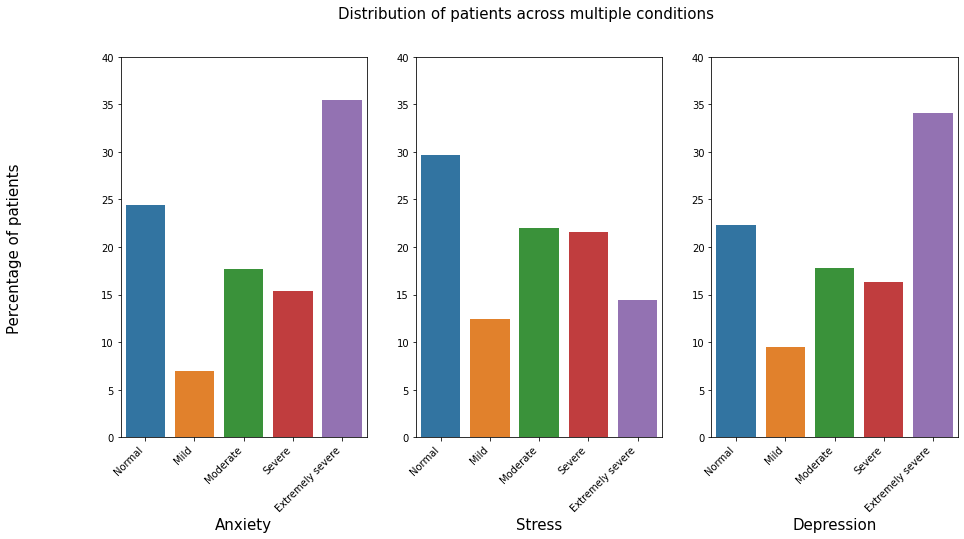

In [130]:
#ploting the conditions
fig, axs = plt.subplots(ncols=3,figsize=(15,7))
fig.suptitle('Distribution of patients across multiple conditions',fontsize=15)
fig.supylabel('Percentage of patients',fontsize=15)
bar_diag(df_anxiety, axs[0],'Anxiety' )
bar_diag(df_stress, axs[1],'Stress' )
bar_diag(df_depression, axs[2],'Depression' )
plt.savefig('/home/juanjo/Documents/Academico/Maestria/proyecto de especializacion/Results/Distribution of patients across multiple conditions.png',bbox_inches="tight")
plt.show()

In [15]:
df_anxiety.drop('score', axis=1, inplace=True)
df_anxiety[useful] = df_filt[useful]
df_depression.drop('score', axis=1, inplace=True)
df_depression[useful] = df_filt[useful]
df_stress.drop('score', axis=1, inplace=True)
df_stress[useful] = df_filt[useful]

/home/juanjo/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/juanjo/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [132]:
def profile(df, condition):
    categorical = df.groupby('diagnosis').agg(lambda x:x.value_counts().index[0])[useful_cat]
    numerical = df[useful_num + ['diagnosis']].groupby('diagnosis').mean().round(2)
    profile = pd.concat([categorical, numerical ], axis=1)
    profile = profile.reindex(['Normal', 'Mild', 'Moderate', 'Severe', 'Extremely severe'])
    profile.reset_index(level=0, inplace=True)
    profile['diagnosis'] = profile['diagnosis'].astype(str) + ' ' + condition
    return profile

In [133]:
stress_profile = profile(df_stress,'stress')
stress_profile.to_latex('/home/juanjo/Documents/Academico/Maestria/proyecto de especializacion/Results/stress_profile.txt', index = False)
stress_profile

diagnosis  education  urban  gender  religion  orientation  \
0  Normal stress            3          3      2       10        1             
1  Mild stress              3          3      2       10        1             
2  Moderate stress          2          3      2       10        1             
3  Severe stress            2          3      2       10        1             
4  Extremely severe stress  2          3      2       10        1             

   race  married  TIPI1  TIPI2  TIPI3  TIPI4  TIPI5  TIPI6  TIPI7  TIPI8  \
0  10    1        4.15   3.65   5.10   3.79   5.36   4.51   5.32   3.76    
1  10    1        3.86   4.02   4.78   4.97   5.06   4.81   5.30   4.21    
2  10    1        3.72   4.26   4.67   5.50   4.90   4.92   5.28   4.38    
3  10    1        3.58   4.54   4.55   6.01   4.69   5.02   5.24   4.57    
4  10    1        3.39   4.84   4.37   6.42   4.37   5.23   5.20   4.82    

   TIPI9  TIPI10    age  familysize  
0  4.84   3.51    25.47  3.61        
1  3.91   3.74    23.66  3.48        
2  3.45   3.75    22.80  3.46        
3  2.91   3.84    22.16  3.44        
4  2.38   3.96    21.69  3.43

In [134]:
anxiety_profile = profile(df_anxiety,'anxiety')
anxiety_profile.to_latex('/home/juanjo/Documents/Academico/Maestria/proyecto de especializacion/Results/anxiety_profile.txt',index = False)
anxiety_profile

diagnosis  education  urban  gender  religion  orientation  \
0  Normal anxiety            3          3      2       10        1             
1  Mild anxiety              3          3      2       10        1             
2  Moderate anxiety          3          3      2       10        1             
3  Severe anxiety            2          3      2       10        1             
4  Extremely severe anxiety  2          3      2       10        1             

   race  married  TIPI1  TIPI2  TIPI3  TIPI4  TIPI5  TIPI6  TIPI7  TIPI8  \
0  10    1        4.17   3.80   5.15   3.81   5.41   4.42   5.27   3.67    
1  10    1        4.01   4.01   4.89   4.71   5.17   4.65   5.28   4.07    
2  10    1        3.80   4.17   4.78   5.11   5.00   4.84   5.25   4.24    
3  10    1        3.68   4.24   4.63   5.53   4.86   4.92   5.29   4.40    
4  10    1        3.52   4.49   4.47   6.08   4.56   5.16   5.28   4.71    

   TIPI9  TIPI10    age  familysize  
0  4.74   3.42    26.94  3.48        
1  4.10   3.63    24.09  3.52        
2  3.77   3.76    23.45  3.54        
3  3.41   3.81    22.36  3.48        
4  2.86   3.92    21.25  3.50

In [135]:
depression_profile = profile(df_depression,'depression')
depression_profile.to_latex('/home/juanjo/Documents/Academico/Maestria/proyecto de especializacion/Results/depression_profile.txt',index = False)
depression_profile

diagnosis  education  urban  gender  religion  \
0  Normal depression            3          3      2       10         
1  Mild depression              3          3      2       10         
2  Moderate depression          3          3      2       10         
3  Severe depression            2          3      2       10         
4  Extremely severe depression  2          3      2       10         

   orientation  race  married  TIPI1  TIPI2  TIPI3  TIPI4  TIPI5  TIPI6  \
0  1            10    1        4.45   3.75   5.34   3.92   5.49   4.24    
1  1            10    1        4.13   4.07   4.99   4.84   5.20   4.60    
2  1            10    1        3.91   4.16   4.79   5.24   5.02   4.80    
3  1            10    1        3.69   4.32   4.62   5.50   4.85   4.92    
4  1            10    1        3.24   4.47   4.32   5.90   4.50   5.31    

   TIPI7  TIPI8  TIPI9  TIPI10    age  familysize  
0  5.41   3.54   4.91   3.38    25.38  3.63        
1  5.35   4.04   4.16   3.63    24.16  3.61        
2  5.31   4.23   3.75   3.73    23.37  3.55        
3  5.28   4.48   3.39   3.79    22.65  3.45        
4  5.14   4.76   2.76   3.95    22.27  3.38

In [136]:
categorical = df_filt.mode()[useful_cat]
numerical = df_filt[useful_num].mean().round(2).to_frame().T
profile = pd.concat([categorical, numerical ], axis=1)
profile.to_latex('/home/juanjo/Documents/Academico/Maestria/proyecto de especializacion/Results/general_profile.txt',index = False)
profile

education  urban  gender  religion  orientation  race  married  TIPI1  \
0  3          3      2       10        1            10    1        3.79    

   TIPI2  TIPI3  TIPI4  TIPI5  TIPI6  TIPI7  TIPI8  TIPI9  TIPI10   age  \
0  4.19   4.74   5.17   4.93   4.85   5.27   4.28   3.65   3.73    23.4   

   familysize  
0  3.5

In [75]:
profile[useful_cat]= profile[useful_cat].astype(int)

<function __main__.profile(df, condition)>

In [17]:
rf_n_estimators = [50,100,200,500,1000]
rf_max_depth = [2,4,6,8,10]
rf_criterion = ['gini', 'entropy']
rf_grid = {'n_estimators': rf_n_estimators,
               'max_depth': rf_max_depth,
               'criterion': rf_criterion,}
rf_n_estimators_str = str(rf_n_estimators).replace('[', '').replace(']', '')
rf_max_depth_str = str(rf_max_depth).replace('[', '').replace(']', '')
rf_criterion_str = str(rf_criterion).replace('[', '').replace(']', '')
parameters_df = pd.DataFrame(data=[rf_n_estimators_str , rf_max_depth_str , rf_criterion_str ], columns = ['Hyperparameter Values'], index = ['Number of trees', 'Max depth', 'Criterion'])
parameters_df.to_latex('/home/juanjo/Documents/Academico/Maestria/proyecto de especializacion/Results/hyperparameters.txt')

In [66]:
def predictive_model(objective, dataset, condition,useful_cat, n_features):
    Y = objective
    x_raw = dataset
    col_trans = make_column_transformer(
                        (OneHotEncoder(),useful_cat),
                        remainder = "passthrough"
                        )
    cat_dumies= []
    for i in useful_cat: 
        for j in  sorted(x_raw[i].unique()):
            cat_dumies.append(i + '_'+ str(j))
    columns = cat_dumies + [x for x in x_raw.columns if x not in useful_cat]
    X = col_trans.fit_transform(x_raw)
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=42)
    clf = RandomForestClassifier()
    rf_n_estimators = [50,100,200,500,1000]
    rf_max_depth = [2,4,6,8,10]
    rf_criterion = ['gini', 'entropy']
    rf_grid = {'n_estimators': rf_n_estimators,
                   'max_depth': rf_max_depth,
                   'criterion': rf_criterion,}
    rf_random = RandomizedSearchCV(estimator = clf, param_distributions = rf_grid, 
                           n_iter = 50, cv = 3, random_state = 42,)
    rf_random.fit(X_train, y_train)
    predictions = rf_random.predict(X_test)
    df = pd.DataFrame( columns = rf_random.best_params_.keys())
    df.loc[0] = list(rf_random.best_params_.values())
    df['accuracy'] = accuracy_score(y_test, predictions)
    df.to_latex('/home/juanjo/Documents/Academico/Maestria/proyecto de especializacion/Results/' +condition +' model.txt',index = False)
    rf = rf_random.best_estimator_
    feat_importances =pd.DataFrame({'names':columns,'importances':rf.feature_importances_})
    feat_importances = feat_importances.nlargest(n_features, 'importances').sort_values('importances')
    #feat_importances = pd.Series(rf.feature_importances_, index=columns)
    
    fig = plt.figure(figsize=(20,10))
    plt.barh( feat_importances['names'], feat_importances['importances'])
    title = condition + ' model Feature importance' 
    fig.suptitle(title, fontsize=20)
    plt.xlabel('Relative importance', fontsize=18)
    plt.yticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.ylabel('Feature', fontsize=16)
    #feat_importance = feat_importances.nlargest(n_features).sort_values('importances',inplace=True)
    
    fig.savefig('/home/juanjo/Documents/Academico/Maestria/proyecto de especializacion/Results/' + title + '.png')
    return(df)

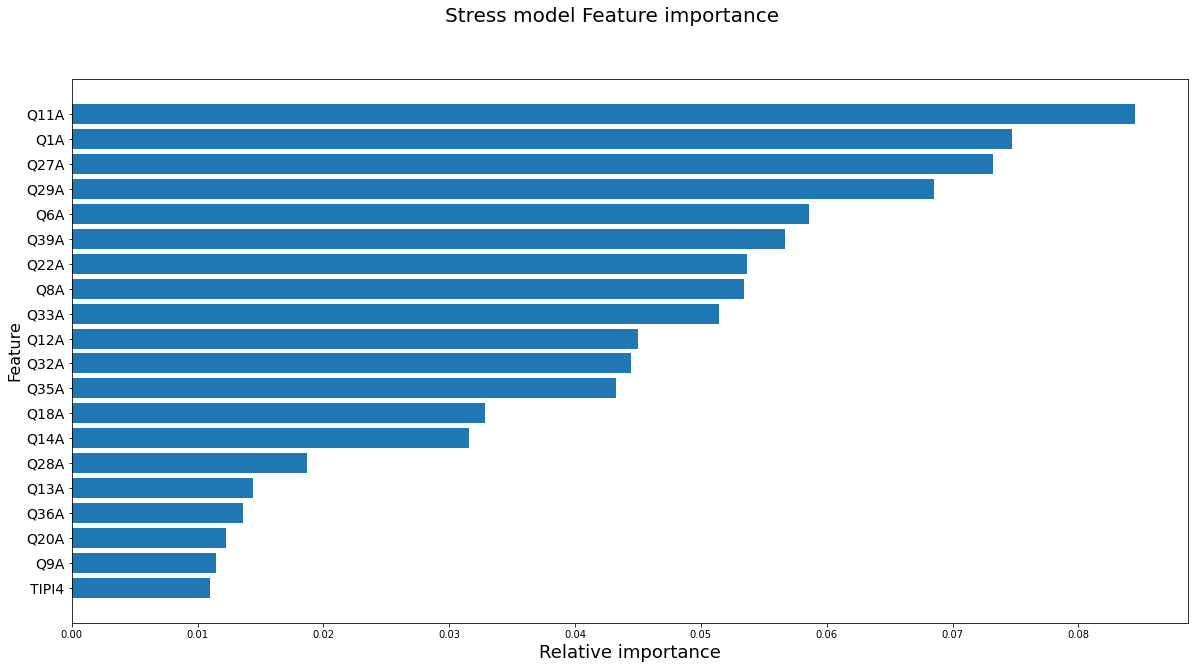

In [182]:
results_stress= predictive_model(df_stress['diagnosis'],df_filt,'Stress', useful_cat, 20)

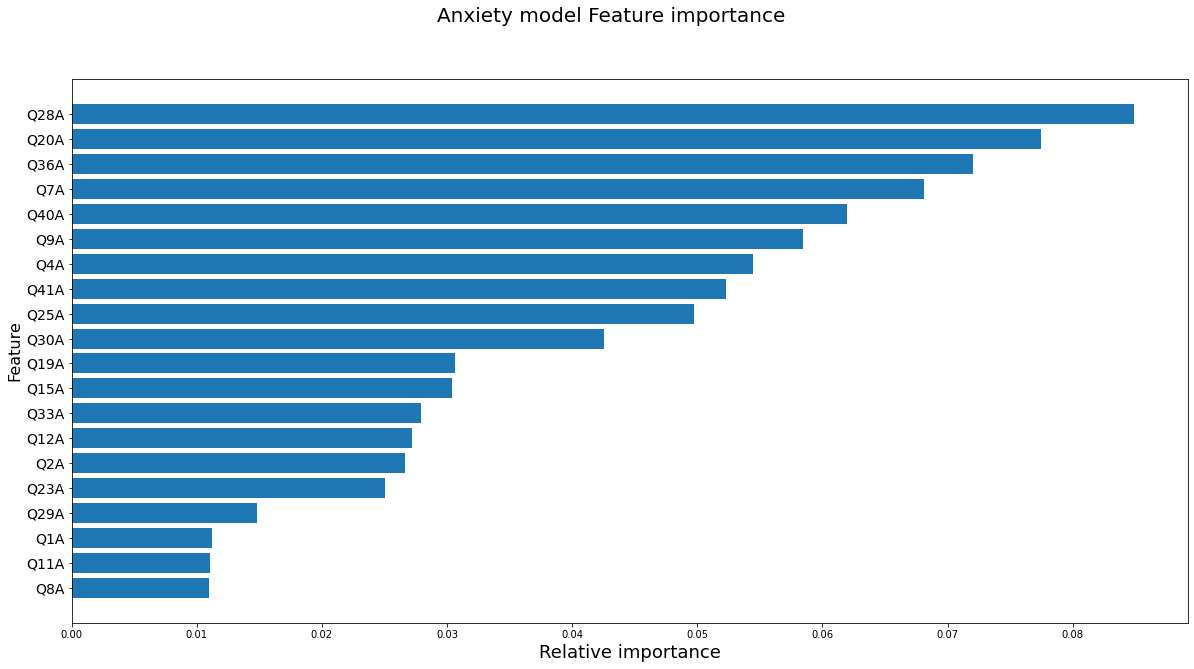

In [183]:
results_anxiety = predictive_model(df_anxiety['diagnosis'],df_filt, 'Anxiety', useful_cat, 20)

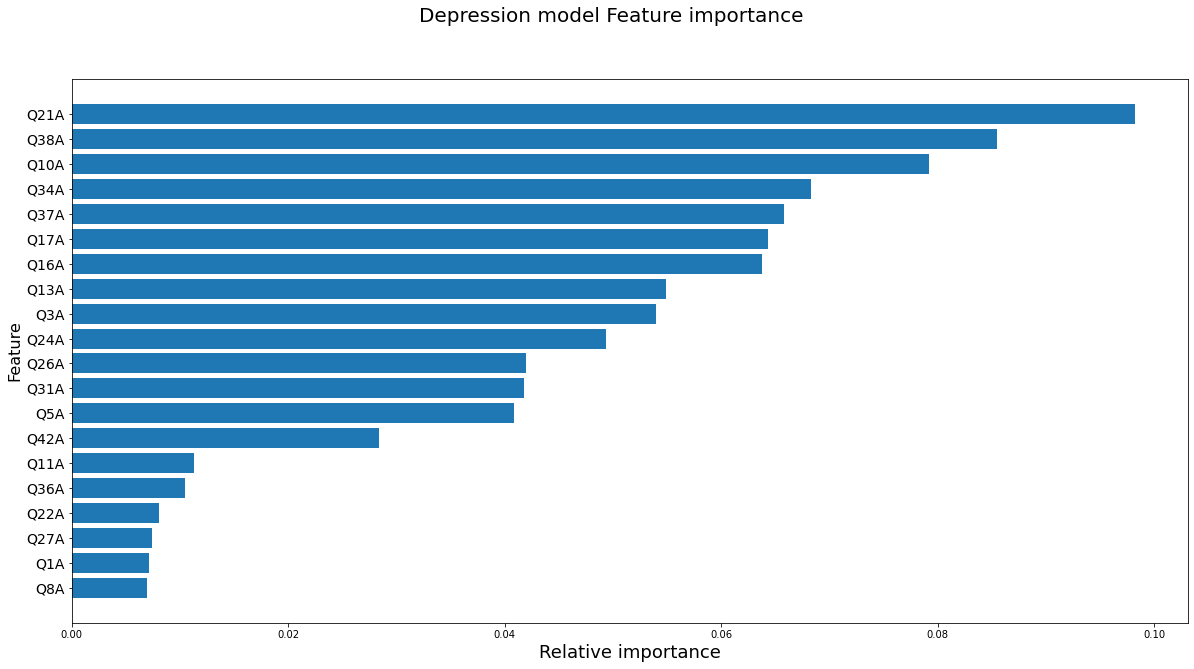

In [184]:
results_depression = predictive_model(df_depression['diagnosis'],df_filt, 'Depression', useful_cat, 20)

In [67]:
df_filt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39759 entries, 0 to 39758
Data columns (total 61 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   Q1A          39759 non-null  int64
 1   Q2A          39759 non-null  int64
 2   Q3A          39759 non-null  int64
 3   Q4A          39759 non-null  int64
 4   Q5A          39759 non-null  int64
 5   Q6A          39759 non-null  int64
 6   Q7A          39759 non-null  int64
 7   Q8A          39759 non-null  int64
 8   Q9A          39759 non-null  int64
 9   Q10A         39759 non-null  int64
 10  Q11A         39759 non-null  int64
 11  Q12A         39759 non-null  int64
 12  Q13A         39759 non-null  int64
 13  Q14A         39759 non-null  int64
 14  Q15A         39759 non-null  int64
 15  Q16A         39759 non-null  int64
 16  Q17A         39759 non-null  int64
 17  Q18A         39759 non-null  int64
 18  Q19A         39759 non-null  int64
 19  Q20A         39759 non-null  int64
 20  Q21A  

In [16]:
df_filt[useful_cat] = df_filt[useful_cat].astype(object)

In [17]:
df_filt[useful_cat].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39759 entries, 0 to 39758
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   education    39759 non-null  object
 1   urban        39759 non-null  object
 2   gender       39759 non-null  object
 3   religion     39759 non-null  object
 4   orientation  39759 non-null  object
 5   race         39759 non-null  object
 6   married      39759 non-null  object
dtypes: object(7)
memory usage: 2.1+ MB


In [18]:
scaler = MinMaxScaler()
df_filt[total_num] = scaler.fit_transform(df_filt[total_num])

In [19]:
catColumnsPos = [df_filt.columns.get_loc(col) for col in list(df_filt.select_dtypes('object').columns)]
print('Categorical columns           : {}'.format(list(df_filt.select_dtypes('object').columns)))
print('Categorical columns position  : {}'.format(catColumnsPos))

Categorical columns           : ['education', 'urban', 'gender', 'religion', 'orientation', 'race', 'married']
Categorical columns position  : [52, 53, 54, 56, 57, 58, 59]


In [20]:
dfMatrix = df_filt.to_numpy()
dfMatrix

array([[1.0, 1.0, 0.3333333333333333, ..., 10, 1, 0.10526315789473684],
       [1.0, 0.0, 0.3333333333333333, ..., 70, 1, 0.21052631578947367],
       [0.6666666666666666, 0.0, 1.0, ..., 60, 1, 0.15789473684210525],
       ...,
       [0.3333333333333333, 0.0, 0.3333333333333333, ..., 30, 2,
        0.15789473684210525],
       [0.6666666666666666, 0.0, 0.3333333333333333, ..., 60, 1,
        0.10526315789473684],
       [0.3333333333333333, 0.0, 0.3333333333333333, ..., 10, 1,
        0.21052631578947367]], dtype=object)

In [73]:
#df_cost.to_csv('/home/juanjo/Documents/Academico/Maestria/proyecto de especializacion/Results/cluster_cost.csv',index = False)
#df_cost = pd.read_csv('/home/juanjo/Documents/Academico/Maestria/proyecto de especializacion/Results/cluster_cost.csv')

/home/juanjo/anaconda3/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 15 x 8 in image.
/home/juanjo/anaconda3/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: /home/juanjo/Documents/Academico/Maestria/proyecto de especializacion/Results/elbow_analysis.png


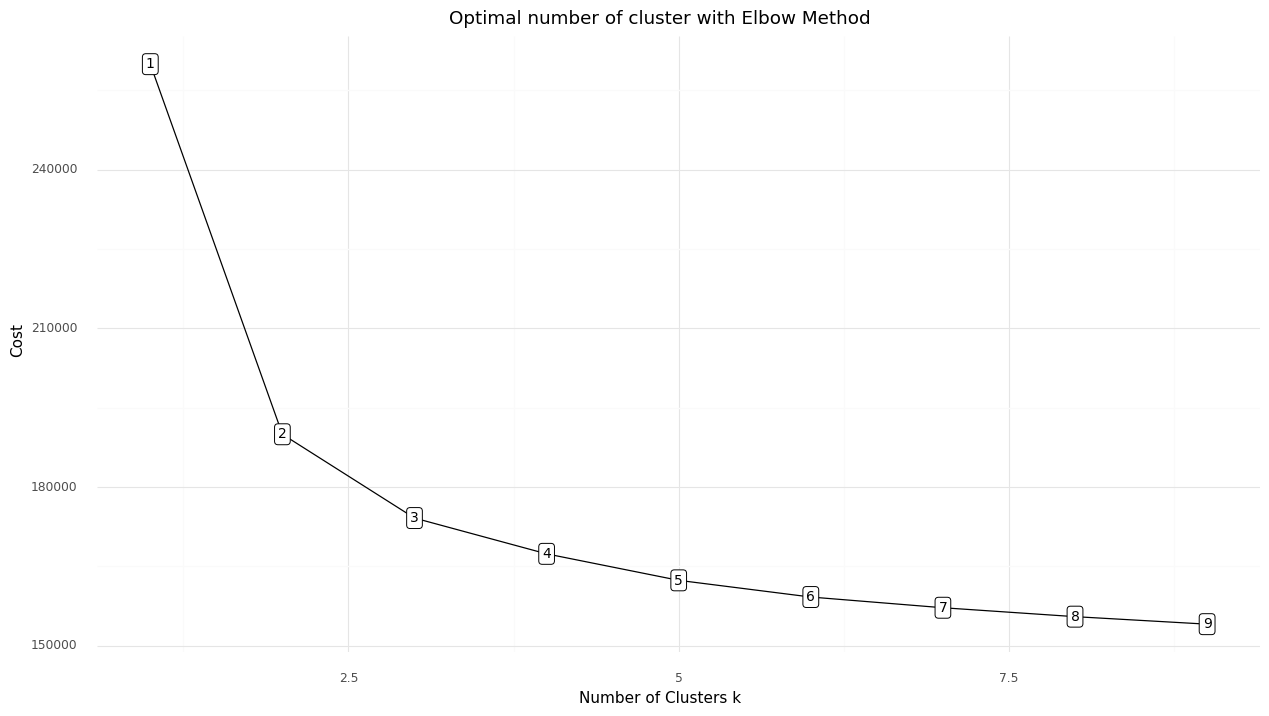

<ggplot: (8775880687987)>

In [11]:
# Choose optimal K using Elbow method
cost = []
for cluster in range(1, 10):
    try:
        kprototype = KPrototypes(n_jobs = -1, n_clusters = cluster, init = 'Huang', random_state = 0)
        kprototype.fit_predict(dfMatrix, categorical = catColumnsPos)
        cost.append(kprototype.cost_)
        print('Cluster initiation: {}'.format(cluster))
    except:
        break
# Converting the results into a dataframe and plotting them
df_cost = pd.DataFrame({'Cluster':range(1, len(cost)+1), 'Cost':cost})
# Data viz
p =(
    ggplot(data = df_cost)+
    geom_line(aes(x = 'Cluster',
                  y = 'Cost'))+
    geom_point(aes(x = 'Cluster',
                   y = 'Cost'))+
    geom_label(aes(x = 'Cluster',
                   y = 'Cost',
                   label = 'Cluster'),
               size = 10) +
    labs(title = 'Optimal number of cluster with Elbow Method')+
    xlab('Number of Clusters k')+
    ylab('Cost')+
    theme_minimal()
)
ggsave(plot = p, filename = 'elbow_analysis.png', path = '/home/juanjo/Documents/Academico/Maestria/proyecto de especializacion/Results')
p

In [22]:
#kprototype = KPrototypes(n_jobs = -1, n_clusters = 4, init = 'Huang', random_state = 0)
#df_filt['Cluster'] = kprototype.fit_predict(dfMatrix, categorical = catColumnsPos) +1
#df_filt['Cluster'].to_csv('/home/juanjo/Documents/Academico/Maestria/proyecto de especializacion/Results/cluster_label.csv',index = False)
df_filt['Cluster'] = pd.read_csv('/home/juanjo/Documents/Academico/Maestria/proyecto de especializacion/Results/cluster_label.csv')

In [23]:
famd = FAMD(n_components =2, n_iter = 20, random_state = 101)
fam_df = famd.fit_transform(df_filt.drop('Cluster', axis =1))
famd.explained_inertia_

array([0.083734  , 0.05654194])

In [24]:
df_filt['Stress_Diagnosis'] = df_stress['diagnosis']
df_filt['Anxiety_Diagnosis'] = df_anxiety['diagnosis']
df_filt['Depression_Diagnosis'] = df_depression['diagnosis']

In [21]:
def vanDongen(ct):
    n2=2*(sum(ct.apply(sum,axis=1)))
    sumi = sum(ct.apply(np.max,axis=1))
    sumj = sum(ct.apply(np.max,axis=0))
    maxsumi = np.max(ct.apply(sum,axis=1))
    maxsumj = np.max(ct.apply(sum,axis=0))
    vd = (n2 - sumi - sumj)/(n2 - maxsumi - maxsumj)
    return vd

In [56]:
tmp = pd.DataFrame({'Stress_Diagnosis': df_filt['Stress_Diagnosis'], 'Clusters': df_filt['Cluster']})# Crear un DataFrame con Labels y Clusters como columnas
ct0 = pd.crosstab(tmp['Stress_Diagnosis'], tmp['Clusters']) # Crear una matriz de confusion: ct
ct0 = ct0.reindex(['Normal', 'Mild', 'Moderate', 'Severe', 'Extremely severe'])
evaluation = {'Van Dongen Criterion': round(vanDongen(ct0),2), 'Adjusted Rand Score': round(adjusted_rand_score(tmp['Stress_Diagnosis'], tmp['Clusters']),2)}
#ct0.reset_index(level=0, inplace=True)
ct0.to_latex('/home/juanjo/Documents/Academico/Maestria/proyecto de especializacion/Results/stress_matrix.txt')
cluster_metrics = pd.DataFrame( columns = evaluation.keys())
cluster_metrics.loc[0] = list(evaluation.values())
cluster_metrics.to_latex('/home/juanjo/Documents/Academico/Maestria/proyecto de especializacion/Results/stress_matrix_metrics.txt',index = False)
print('Indice de Van Dongen:',evaluation['Van Dongen Criterion'])
print('Indice de Rand:',evaluation['Adjusted Rand Score'])
ct0

Indice de Van Dongen: 0.54
Indice de Rand: 0.37


Clusters             1     2     3     4
Stress_Diagnosis                        
Normal            3     907   9743  1143
Mild              9     1114  1090  2708
Moderate          402   3442  212   4671
Severe            3745  2717  6     2102
Extremely severe  5214  249   0     282

In [60]:
ct = ct0
n2=2*(sum(ct.apply(sum,axis=1)))
sumi = sum(ct.apply(np.max,axis=1))
sumj = sum(ct.apply(np.max,axis=0))
maxsumi = np.max(ct.apply(sum,axis=1))
maxsumj = np.max(ct.apply(sum,axis=0))
vd = (n2 - sumi - sumj)/(n2 - maxsumi - maxsumj)

In [38]:
sns.color_palette('Set1')[0:len(unique)]

[(0.8941176470588236, 0.10196078431372549, 0.10980392156862745),
 (0.21568627450980393, 0.49411764705882355, 0.7215686274509804),
 (0.30196078431372547, 0.6862745098039216, 0.2901960784313726),
 (0.596078431372549, 0.3058823529411765, 0.6392156862745098),
 (1.0, 0.4980392156862745, 0.0),
 (1.0, 1.0, 0.2),
 (0.6509803921568628, 0.33725490196078434, 0.1568627450980392),
 (0.9686274509803922, 0.5058823529411764, 0.7490196078431373),
 (0.6, 0.6, 0.6)]

In [48]:
unique = df_stress['diagnosis'].unique()
palette = dict(zip(unique, sns.color_palette('Set1')[0:len(unique)]))

In [55]:
unique

array(['Extremely severe', 'Severe', 'Mild', 'Normal', 'Moderate'],
      dtype=object)

In [54]:
palette

{'Extremely severe': (0.8941176470588236,
  0.10196078431372549,
  0.10980392156862745),
 'Severe': (0.21568627450980393, 0.49411764705882355, 0.7215686274509804),
 'Mild': (0.30196078431372547, 0.6862745098039216, 0.2901960784313726),
 'Normal': (0.596078431372549, 0.3058823529411765, 0.6392156862745098),
 'Moderate': (1.0, 0.4980392156862745, 0.0)}

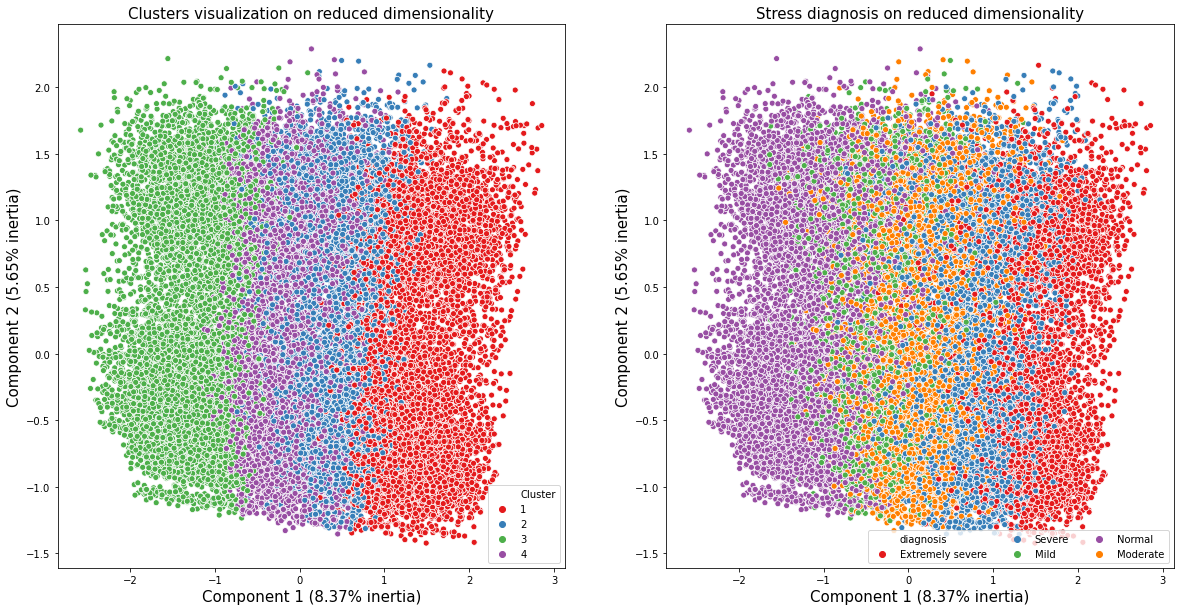

In [51]:

fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(20,10))
sns.scatterplot(x=fam_df[0], y=fam_df[1], hue=df_filt['Cluster'], 
                palette="Set1", ax=axes[0])
sns.scatterplot(x=fam_df[0], y=fam_df[1], hue=df_stress['diagnosis'], 
                palette=palette, ax=axes[1])
axes[1].legend(ncol=3, fontsize=10, loc='lower right')
axes[0].legend(ncol=1, fontsize=10, loc='lower right')
axes[0].set_title('Clusters visualization on reduced dimensionality', fontsize=15)
axes[1].set_title('Stress diagnosis on reduced dimensionality', fontsize=15)
axes[0].set_xlabel("Component 1 (" + str(round(famd.explained_inertia_[0]*100,2)) + '% inertia)', fontsize=15)
axes[0].set_ylabel("Component 2 (" + str(round(famd.explained_inertia_[1]*100,2)) + '% inertia)', fontsize=15)
axes[1].set_xlabel("Component 1 (" + str(round(famd.explained_inertia_[0]*100,2)) + '% inertia)', fontsize=15)
axes[1].set_ylabel("Component 2 (" + str(round(famd.explained_inertia_[1]*100,2)) + '% inertia)', fontsize=15)
fig.savefig('/home/juanjo/Documents/Academico/Maestria/proyecto de especializacion/Results/stress_clusters.png')
plt.show()

In [50]:
tmp = pd.DataFrame({'Anxiety_Diagnosis': df_filt['Anxiety_Diagnosis'], 'Clusters': df_filt['Cluster']})# Crear un DataFrame con Labels y Clusters como columnas
ct0 = pd.crosstab(tmp['Anxiety_Diagnosis'], tmp['Clusters']) # Crear una matriz de confusion: ct
ct0 = ct0.reindex(['Normal', 'Mild', 'Moderate', 'Severe', 'Extremely severe'])
ct0.to_latex('/home/juanjo/Documents/Academico/Maestria/proyecto de especializacion/Results/anxiety_matrix.txt')
evaluation = {'Van Dongen Criterion': round(vanDongen(ct0),2), 'Adjusted Rand Score': round(adjusted_rand_score(tmp['Anxiety_Diagnosis'], tmp['Clusters']),2)}
cluster_metrics = pd.DataFrame( columns = evaluation.keys())
cluster_metrics.loc[0] = list(evaluation.values())
cluster_metrics.to_latex('/home/juanjo/Documents/Academico/Maestria/proyecto de especializacion/Results/anxiety_matrix_metrics.txt',index = False)
print('Indice de Van Dongen:',vanDongen(ct0))
print('Indice de Rand:',adjusted_rand_score(tmp['Anxiety_Diagnosis'], tmp['Clusters']))
ct0

Indice de Van Dongen: 0.5839128674982522
Indice de Rand: 0.3368775994320651


Clusters              1     2     3     4
Anxiety_Diagnosis                        
Normal             0     1031  7928  766 
Mild               0     549   1380  834 
Moderate           10    2216  1519  3302
Severe             228   2561  213   3109
Extremely severe   9135  2072  11    2895

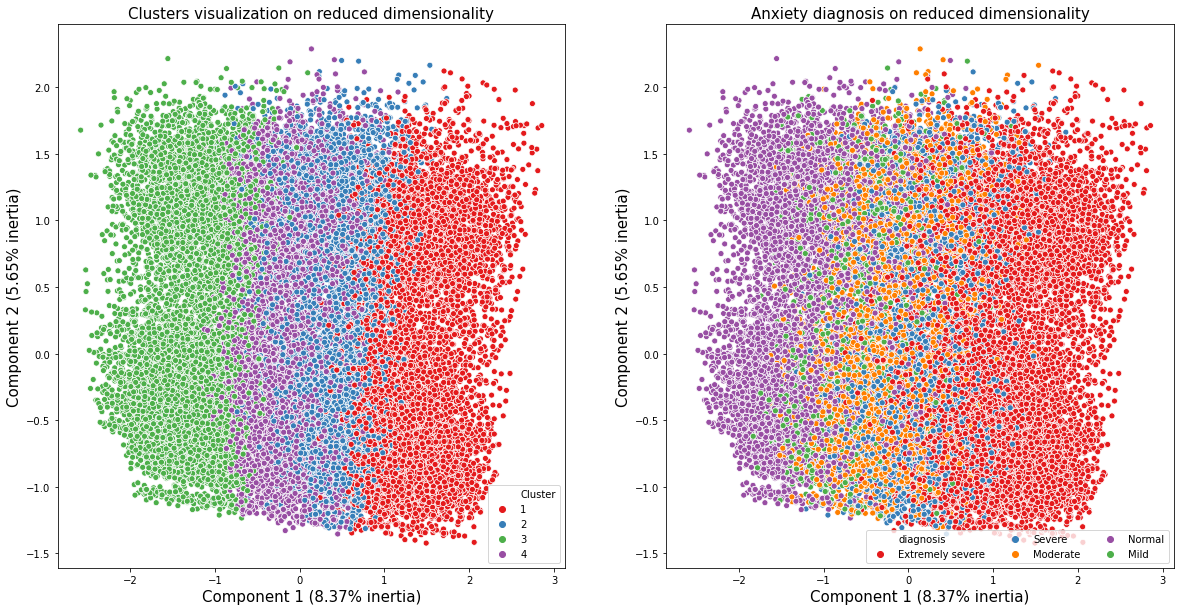

In [52]:

fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(20,10))
sns.scatterplot(x=fam_df[0], y=fam_df[1], hue=df_filt['Cluster'], 
                palette="Set1", ax=axes[0])
sns.scatterplot(x=fam_df[0], y=fam_df[1], hue=df_anxiety['diagnosis'], 
                palette=palette, ax=axes[1])
axes[1].legend(ncol=3, fontsize=10, loc='lower right')
axes[0].legend(ncol=1, fontsize=10, loc='lower right')
axes[0].set_title('Clusters visualization on reduced dimensionality', fontsize=15)
axes[1].set_title('Anxiety diagnosis on reduced dimensionality', fontsize=15)
axes[0].set_xlabel("Component 1 (" + str(round(famd.explained_inertia_[0]*100,2)) + '% inertia)', fontsize=15)
axes[0].set_ylabel("Component 2 (" + str(round(famd.explained_inertia_[1]*100,2)) + '% inertia)', fontsize=15)
axes[1].set_xlabel("Component 1 (" + str(round(famd.explained_inertia_[0]*100,2)) + '% inertia)', fontsize=15)
axes[1].set_ylabel("Component 2 (" + str(round(famd.explained_inertia_[1]*100,2)) + '% inertia)', fontsize=15)
fig.savefig('/home/juanjo/Documents/Academico/Maestria/proyecto de especializacion/Results/anxiety_clusters.png')
plt.show()

In [51]:
tmp = pd.DataFrame({'Depression_Diagnosis': df_filt['Depression_Diagnosis'], 'Clusters': df_filt['Cluster']})# Crear un DataFrame con Labels y Clusters como columnas
ct0 = pd.crosstab(tmp['Depression_Diagnosis'], tmp['Clusters']) # Crear una matriz de confusion: ct
ct0 = ct0.reindex(['Normal', 'Mild', 'Moderate', 'Severe', 'Extremely severe'])
ct0.to_latex('/home/juanjo/Documents/Academico/Maestria/proyecto de especializacion/Results/depression_matrix.txt')
evaluation = {'Van Dongen Criterion': round(vanDongen(ct0),2), 'Adjusted Rand Score': round(adjusted_rand_score(tmp['Depression_Diagnosis'], tmp['Clusters']),2)}
cluster_metrics = pd.DataFrame( columns = evaluation.keys())
cluster_metrics.loc[0] = list(evaluation.values())
cluster_metrics.to_latex('/home/juanjo/Documents/Academico/Maestria/proyecto de especializacion/Results/depression_matrix_metrics.txt',index = False)
print('Indice de Van Dongen:',vanDongen(ct0))
print('Indice de Rand:',adjusted_rand_score(tmp['Depression_Diagnosis'], tmp['Clusters']))
ct0

Indice de Van Dongen: 0.4884699453551913
Indice de Rand: 0.3964116912502817


Clusters                 1     2     3     4
Depression_Diagnosis                        
Normal                0     0     7655  1198
Mild                  13    0     1836  1937
Moderate              209   7     1278  5583
Severe                1218  2803  267   2188
Extremely severe      7933  5619  15    0

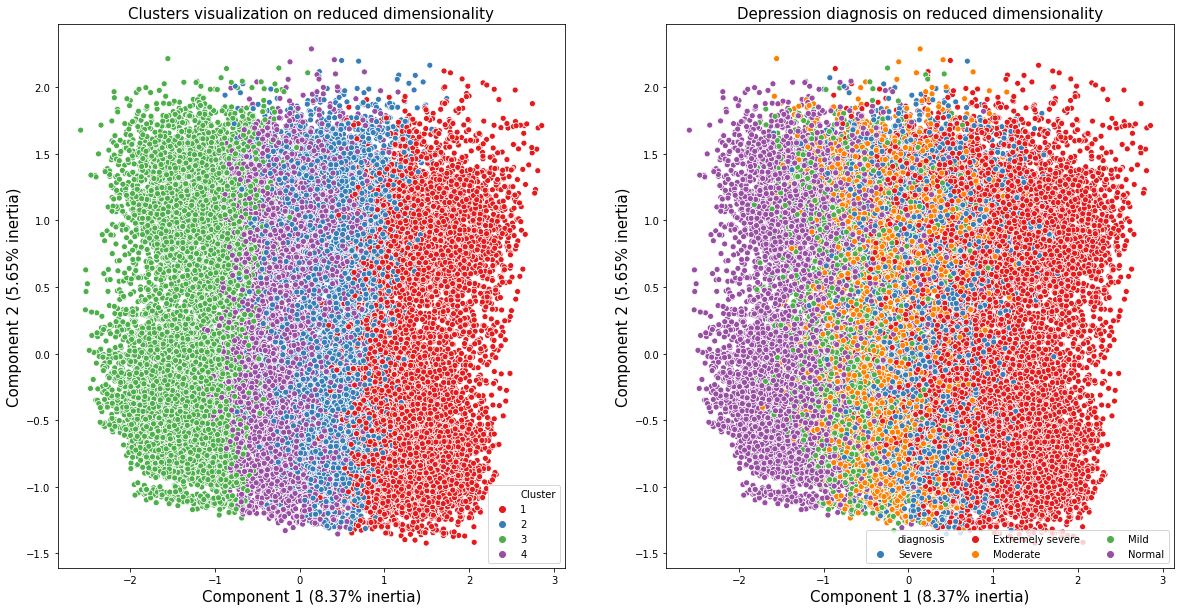

In [53]:

fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(20,10))
sns.scatterplot(x=fam_df[0], y=fam_df[1], hue=df_filt['Cluster'], 
                palette="Set1", ax=axes[0])
sns.scatterplot(x=fam_df[0], y=fam_df[1], hue=df_depression['diagnosis'], 
                palette=palette, ax=axes[1])
axes[1].legend(ncol=3, fontsize=10, loc='lower right')
axes[0].legend(ncol=1, fontsize=10, loc='lower right')
axes[0].set_title('Clusters visualization on reduced dimensionality', fontsize=15)
axes[1].set_title('Depression diagnosis on reduced dimensionality', fontsize=15)
axes[0].set_xlabel("Component 1 (" + str(round(famd.explained_inertia_[0]*100,2)) + '% inertia)', fontsize=15)
axes[0].set_ylabel("Component 2 (" + str(round(famd.explained_inertia_[1]*100,2)) + '% inertia)', fontsize=15)
axes[1].set_xlabel("Component 1 (" + str(round(famd.explained_inertia_[0]*100,2)) + '% inertia)', fontsize=15)
axes[1].set_ylabel("Component 2 (" + str(round(famd.explained_inertia_[1]*100,2)) + '% inertia)', fontsize=15)
fig.savefig('/home/juanjo/Documents/Academico/Maestria/proyecto de especializacion/Results/depression_clusters.png')
plt.show()

In [76]:
df_filt['stress diagnosis'] = df_stress['diagnosis'].astype(object)
df_filt['anxiety diagnosis'] = df_anxiety['diagnosis'].astype(object)
df_filt['depression diagnosis'] = df_depression['diagnosis'].astype(object)

In [12]:
categorical = df_filt.groupby('Cluster').median(numeric_only=False)[useful_cat]
numerical = df_filt[useful_num +['Cluster'] ].groupby('Cluster').mean().round(2)
profile = pd.concat([categorical, numerical ], axis=1)
profile.to_latex('/home/juanjo/Documents/Academico/Maestria/proyecto de especializacion/Results/clusters_profiles.txt')
profile

education  urban  gender  religion  orientation  race  married  \
Cluster                                                                   
1        2.0        2.0    2.0     10.0      1.0          10.0  1.0       
2        2.0        2.0    2.0     10.0      1.0          10.0  1.0       
3        3.0        2.0    2.0     10.0      1.0          10.0  1.0       
4        3.0        2.0    2.0     10.0      1.0          10.0  1.0       

         TIPI1  TIPI2  TIPI3  TIPI4  TIPI5  TIPI6  TIPI7  TIPI8  TIPI9  \
Cluster                                                                  
1        3.39   4.66   4.35   6.30   4.40   5.27   5.22   4.87   2.55    
2        3.25   4.23   4.38   5.39   4.71   5.18   5.12   4.53   3.18    
3        4.33   3.68   5.23   3.75   5.45   4.36   5.36   3.65   4.95    
4        3.99   4.28   4.86   5.47   5.04   4.73   5.36   4.23   3.65    

         TIPI10    age  familysize  
Cluster                             
1        4.00    21.20  3.48        
2        3.84    23.22  3.29        
3        3.45    25.97  3.64        
4        3.71    22.83  3.53

In [78]:
inter = df_filt.groupby('Cluster').agg(
    {
        
        'stress diagnosis': lambda x: x.value_counts().index[0],
        'anxiety diagnosis': lambda x: x.value_counts().index[0],
        'depression diagnosis': lambda x: x.value_counts().index[0],
       
    }
)
inter.to_latex('/home/juanjo/Documents/Academico/Maestria/proyecto de especializacion/Results/clusters_diagnosis.txt')
inter

stress diagnosis anxiety diagnosis depression diagnosis
Cluster                                                         
1        Extremely severe  Extremely severe  Extremely severe   
2        Moderate          Severe            Extremely severe   
3        Normal            Normal            Normal             
4        Moderate          Moderate          Moderate

In [141]:
X = col_trans.fit_transform(df_depression)

In [142]:
pd.DataFrame(X).head()

0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22  \
0  0  0  1  0  0  0  0  0  1  1  3  0  3  3  2  0  3  3  3  2  0  1  3   
1  0  0  1  0  0  0  0  0  1  1  3  1  3  2  3  1  1  2  1  1  3  1  1   
2  0  0  1  0  0  0  0  0  1  3  3  3  3  3  3  3  3  0  3  3  3  3  3   
3  0  1  0  0  0  0  0  0  1  1  2  2  0  1  2  0  0  1  2  3  1  0  1   
4  0  0  0  1  0  0  0  1  0  2  3  2  3  2  3  2  1  3  2  3  2  2  2   

                 23 24 25 26 27 28 29 30 31 32 33 34  35  36 37  38 39 40  
0  Severe            1  5  7  7  7  7  7  5  1  1  2  16  12  1  10  1  2  
1  Severe            6  5  4  7  5  4  7  7  1  5  2  16  7   0  70  1  4  
2  Extremely severe  2  5  2  2  5  6  5  5  3  2  2  17  4   3  60  1  3  
3  Moderate          1  1  7  4  6  4  6  1  6  1  2  13  4   5  70  1  5  
4  Extremely severe  2  5  3  6  5  5  5  6  3  3  2  19  10  1  10  1  4

In [120]:
df_depression.head()

Q3A  Q5A  Q10A  Q13A  Q16A  Q17A  Q21A  Q24A  Q26A  Q31A  Q34A  Q37A  Q38A  \
0  1    3    0     3     3     2     0     3     3     3     2     0     1      
1  1    3    1     3     2     3     1     1     2     1     1     3     1      
2  3    3    3     3     3     3     3     3     0     3     3     3     3      
3  1    2    2     0     1     2     0     0     1     2     3     1     0      
4  2    3    2     3     2     3     2     1     3     2     3     2     2      

   Q42A         diagnosis  TIPI1  TIPI2  TIPI3  TIPI4  TIPI5  TIPI6  TIPI7  \
0  3     Severe            1      5      7      7      7      7      7       
1  1     Severe            6      5      4      7      5      4      7       
2  3     Extremely severe  2      5      2      2      5      6      5       
3  1     Moderate          1      1      7      4      6      4      6       
4  2     Extremely severe  2      5      3      6      5      5      5       

   TIPI8  TIPI9  TIPI10  education  urban  gender  age  religion  orientation  \
0  5      1      1       2          3      2       16   12        1             
1  7      1      5       2          3      2       16   7         0             
2  5      3      2       2          3      2       17   4         3             
3  1      6      1       1          3      2       13   4         5             
4  6      3      3       3          2      2       19   10        1             

   race  married  familysize  
0  10    1        2           
1  70    1        4           
2  60    1        3           
3  70    1        5           
4  10    1        4

In [163]:
cat_dumies= []
for i in useful_cat: 
    for j in  sorted(df_depression[i].unique()):
        cat_dumies.append(i + '_'+ str(j))

In [173]:
columns = cat_dumies + [x for x in df_depression.columns if x not in useful_cat]

In [181]:
columns.remove('diagnosis')

In [160]:
sorted(df_depression['education'].unique())

[0, 1, 2, 3, 4]

In [182]:
columns

['education_0',
 'education_1',
 'education_2',
 'education_3',
 'education_4',
 'urban_0',
 'urban_1',
 'urban_2',
 'urban_3',
 'gender_0',
 'gender_1',
 'gender_2',
 'gender_3',
 'religion_0',
 'religion_1',
 'religion_2',
 'religion_3',
 'religion_4',
 'religion_5',
 'religion_6',
 'religion_7',
 'religion_8',
 'religion_9',
 'religion_10',
 'religion_11',
 'religion_12',
 'orientation_0',
 'orientation_1',
 'orientation_2',
 'orientation_3',
 'orientation_4',
 'orientation_5',
 'race_10',
 'race_20',
 'race_30',
 'race_40',
 'race_50',
 'race_60',
 'race_70',
 'married_0',
 'married_1',
 'married_2',
 'married_3',
 'Q3A',
 'Q5A',
 'Q10A',
 'Q13A',
 'Q16A',
 'Q17A',
 'Q21A',
 'Q24A',
 'Q26A',
 'Q31A',
 'Q34A',
 'Q37A',
 'Q38A',
 'Q42A',
 'TIPI1',
 'TIPI2',
 'TIPI3',
 'TIPI4',
 'TIPI5',
 'TIPI6',
 'TIPI7',
 'TIPI8',
 'TIPI9',
 'TIPI10',
 'age',
 'familysize']